# Keyness Analysis Per Theme

In [1]:
# This reload library is just used for developing the notebook
# code and can be removed once this is stable.
%reload_ext autoreload
%autoreload 2

In [2]:
import ast
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.topic_summary import ModelAnalyser, NurGenreMapper, ReviewExtractor

/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users

#### Set paths and load functions

In [3]:
# please adjust the following paths to reflect the location of the following files in your local directory

impact_file = '../data/review-impact_matches.tsv.gz'
raw_review_data = '../data/reviews-stats.tsv.gz'
isbn_map = "../data/work-isbn-mapping.tsv"
isbn_work_id_mappings_file = "../data/work_isbn_title_genre.tsv.gz"
isbn_topic_file = '../data/isbn_topic_scores.tsv.gz'

## Read information on ISBN, Topic and Theme

In [9]:
isbn_topic = pd.read_csv(isbn_topic_file, sep='\t', compression='gzip', dtype={'isbn': str})
isbn_topic['themes'] = isbn_topic.themes.apply(lambda x: x.split(';'))
isbn_topic

,isbn,topic,score,themes
0,9789045020860,150,0.700171,"[geography & setting, culture]"
1,9789403127705,17,0.620962,[reli. / spirit. / phil.]
2,9789025440879,25,0.325808,"[culture, family]"
3,9789026152412,181,0.600034,"[behaviours / feelings, family]"
4,9789021572246,56,0.655904,[medicine / health]
...,...,...,...,...
19228,9789029731027,21,0.407154,[lifestyle & sport]
19229,9789021560229,15,0.399528,[reli. / spirit. / phil.]
19230,9789020411324,102,0.572321,"[culture, travel & transport]"
19231,9789460415210,6,0.597047,[other]


In [10]:
isbn_theme = isbn_topic.explode('themes')[['isbn', 'themes']].set_index('isbn')
isbn_theme = pd.get_dummies(isbn_theme).reset_index().groupby('isbn').sum().reset_index()
isbn_theme

,isbn,themes_behaviours / feelings,themes_crime,themes_culture,themes_economy & work,themes_family,themes_geography & setting,themes_history,themes_lifestyle & sport,themes_medicine / health,themes_other,themes_politics,themes_reli. / spirit. / phil.,themes_romance & sex,themes_science,themes_society,"themes_super., fantasy & sci-fi",themes_travel & transport,themes_war,themes_wildlife / nature
0,9789020200485,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,9789020201451,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,9789020202106,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,9789020205008,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,9789020205268,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18462,9789493189560,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18463,9789493189584,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18464,9789493189607,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18465,9789493189669,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [4]:
isbn_topic = pd.read_csv(isbn_topic_file, sep='\t', compression='gzip', dtype={'isbn': str})

# Turn the theme string into a Python list object
isbn_topic['themes'] = isbn_topic.themes.apply(ast.literal_eval)

# explode the themes lists so that each theme is column and rows indicate 
# whether an ISBN has been assigned to a theme.
isbn_theme = isbn_topic.explode('themes')[['isbn', 'themes']].set_index('isbn')
isbn_theme = pd.get_dummies(isbn_theme).reset_index().groupby('isbn').sum().reset_index()
isbn_theme

,isbn,themes_Arts,themes_Behaviours / feelings,themes_Crime,themes_Culture,themes_Geography and setting,themes_History,themes_Law,themes_Lifestyle and sport,themes_Medicine / health,themes_Other,themes_Politics,"themes_Religion, spirituality and philosophy",themes_Romance and sex,themes_School,"themes_Supernatural, fantasy and sci-fi",themes_War,themes_Wildlife / nature
0,9789020200485,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,9789020201451,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,9789020202106,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,9789020205008,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,9789020205268,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18462,9789493189560,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
18463,9789493189584,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18464,9789493189607,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
18465,9789493189669,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Combine Work identifier and Genre to Topic and Theme information

In [11]:
from impfic_core.map.map_genre import read_genre_file

# read work genre mapping
work_genre = read_genre_file(isbn_work_id_mappings_file)
work_genre = work_genre[work_genre.record_id_type == 'isbn'].rename(columns={'record_id': 'isbn'})
work_genre = work_genre[['work_id', 'isbn', 'nur_genre']]
work_genre.shape

(189038, 3)

In [12]:
# merge and drop the ISBN column, since we need only the work_id to link
# topic and theme to the reviews and impact terms
work_genre_theme = pd.merge(work_genre, isbn_theme, on='isbn').drop('isbn', axis=1)

# get a list of all the column names for the themes
theme_cols = [col for col in work_genre_theme.columns if col.startswith('themes_')]

# make sure that per book, each theme is counted only once
for theme_col in theme_cols:
    work_genre_theme[theme_col] = work_genre_theme[theme_col].apply(lambda x: 0 if x == 0 else 1)

# the collection has 18,465 books, so there should be 18,465 rows
work_genre_theme.shape

(18465, 21)

In [37]:
# check that per book, no theme is counted more than once
work_genre_theme[theme_cols].max(axis=0)

themes_behaviours / feelings       1
themes_crime                       1
themes_culture                     1
themes_economy & work              1
themes_family                      1
themes_geography & setting         1
themes_history                     1
themes_lifestyle & sport           1
themes_medicine / health           1
themes_other                       1
themes_politics                    1
themes_reli. / spirit. / phil.     1
themes_romance & sex               1
themes_science                     1
themes_society                     1
themes_super., fantasy & sci-fi    1
themes_travel & transport          1
themes_war                         1
themes_wildlife / nature           1
dtype: int64

In [13]:
# Some insight in the distribution of books over genres
work_genre_theme.nur_genre.value_counts() / len(work_genre_theme)

Literary_fiction      0.298890
Non-fiction           0.284538
Other fiction         0.108042
Suspense              0.092066
Regional_fiction      0.047983
Literary_thriller     0.044571
Children_fiction      0.030219
Romanticism           0.028703
Young_adult           0.026807
Fantasy_fiction       0.019767
Historical_fiction    0.018413
Name: nur_genre, dtype: float64

In [19]:
work_genre_theme

,work_id,nur_genre,themes_behaviours / feelings,themes_crime,themes_culture,themes_economy & work,themes_family,themes_geography & setting,themes_history,themes_lifestyle & sport,...,themes_other,themes_politics,themes_reli. / spirit. / phil.,themes_romance & sex,themes_science,themes_society,"themes_super., fantasy & sci-fi",themes_travel & transport,themes_war,themes_wildlife / nature
0,impfic-work-6,Suspense,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,impfic-work-10,Non-fiction,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,impfic-work-19,Other fiction,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,impfic-work-23,Literary_fiction,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,impfic-work-24,Historical_fiction,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18460,impfic-work-118714,Fantasy_fiction,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18461,impfic-work-118715,Fantasy_fiction,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
18462,impfic-work-118716,Romanticism,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
18463,impfic-work-118717,Suspense,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:

# read review metadata
review_stats = pd.read_csv(raw_review_data, sep='\t', compression='gzip')

# merge review metadata and genre data
review_stats = pd.merge(review_stats, work_genre[['work_id', 'nur_genre']].drop_duplicates(), 
                        on='work_id', how='left')

# review professional reviews
review_stats = review_stats[review_stats.source != 'NBD_Biblion']


In [15]:
print('number of reviews:', len(review_stats))
review_stats.nur_genre.value_counts() / len(review_stats)

number of reviews: 634614


Literary_fiction      0.298400
Non-fiction           0.148594
Literary_thriller     0.118297
Suspense              0.103085
Other fiction         0.053837
Young_adult           0.044741
Children_fiction      0.039093
Fantasy_fiction       0.019913
Romanticism           0.009792
Historical_fiction    0.005120
Regional_fiction      0.002164
Name: nur_genre, dtype: float64

Since themes can have overlap (the same topic assigned to multiple themes, leads to books of that topic to be assigned to multiple themes)

Number of books with multiple themes:

### Counting number of words per theme

- **target corpus size**: sum of number of words of reviews of works in theme
- **reference corpus size**: sum of number of words of reviews of works _not_ in theme



In [16]:
review_work_theme = pd.merge(review_stats, work_genre_theme, on='work_id', how='right')

print('number of reviews (with duplicates for works with multiple themes):', review_work_theme.shape)


number of reviews (with duplicates for works with multiple themes): (140511, 31)


,work_id,nur_genre,themes_behaviours / feelings,themes_crime,themes_culture,themes_economy & work,themes_family,themes_geography & setting,themes_history,themes_lifestyle & sport,...,themes_other,themes_politics,themes_reli. / spirit. / phil.,themes_romance & sex,themes_science,themes_society,"themes_super., fantasy & sci-fi",themes_travel & transport,themes_war,themes_wildlife / nature


In [31]:
work_genre_theme[theme_cols].sum(axis=1).value_counts()

1    11086
2     5815
3     1468
4       94
5        2
dtype: int64

Half of the books in the corpus have a single theme, the other half of the books have two themes. Only a handful have 3 or 4 themes.

In [39]:
# compute the size of the _target_ and _reference_ corpus 
targets = []
refs = []
for theme_col in theme_cols:
    target = review_work_theme[review_work_theme[theme_col] == 1].review_num_words.sum()
    ref = review_work_theme[review_work_theme[theme_col] == 0].review_num_words.sum()
    targets.append(target)
    refs.append(ref)

#
target_total = review_work_theme.review_num_words.sum()
ref = 0
targets.append(target_total)
refs.append(ref)

review_theme_totals = pd.DataFrame(data = {
    'theme': [col.replace('themes_', '') for col in theme_cols] + ['Total'], 
    'target_freq': targets, 
    'ref_freq': refs
}).set_index('theme')

review_theme_totals

,target_freq,ref_freq
theme,,
behaviours / feelings,3780059.0,18905124.0
crime,3888933.0,18796250.0
culture,5125946.0,17559237.0
economy & work,319740.0,22365443.0
family,513642.0,22171541.0
geography & setting,6342743.0,16342440.0
history,2299517.0,20385666.0
lifestyle & sport,331922.0,22353261.0
medicine / health,434327.0,22250856.0


In [45]:
# Read the impact matches and select column to identify each instance of
# an impact term (review_id, sentence_index and match_index determine 
# which token(s) make up the impact term) for each impact type.

# Multiple rules can identify the same token(s) as expressing the same
# impact type, but we only want to count those token(s) once.
impact_matches = pd.read_csv(impact_file, sep='\t', compression='gzip')

print('total number of impact matches:', len(impact_matches))

impact_matches = impact_matches[['review_id', 'sentence_index', 'match_index', 'impact_type', 'impact_term']].drop_duplicates()
print('total number of distinct impact instances:', len(impact_matches))

# drop reflection impact matches, as reflection is not a validated impact type
impact_matches = impact_matches[impact_matches.impact_type != 'Reflection']

print('total number of distinct impact instances after dropping reflection matches:', len(impact_matches))

impact_matches = impact_matches[impact_matches.review_id.isin(review_stats.review_id.unique())]

print('total number of distinct impact instances after dropping matches in NBD Biblion reviews:', len(impact_matches))



total number of impact matches: 2423804
total number of distinct impact instances: 2392079
total number of distinct impact instances after dropping reflection matches: 2110363
total number of distinct impact instances after dropping matches in NBD Biblion reviews: 2058073


Now merge the impact matches with the work_id and review_id and then with the theme information.

In [46]:
# How many different impact terms are used across all reviews?
impact_matches.groupby('impact_type').impact_term.nunique()

impact_type
Affect       49
Narrative    85
Style        56
Name: impact_term, dtype: int64

In [47]:
work_review_impact = (pd.merge(review_stats[['work_id', 'review_id']], impact_matches, on='review_id', how='inner')
                      .drop(['sentence_index', 'match_index'], axis=1))

print('number of impact matches:', len(work_review_impact))

number of impact matches: 2058101


In [48]:
impact_theme = pd.merge(work_review_impact, 
                        work_genre_theme, 
                        on='work_id', 
                        how='inner')

print('number of impact matches:', len(impact_theme))

number of impact matches: 468046


### Compute Size of Target and Reference Corpora

In [49]:
theme_cols = [col for col in impact_theme.columns if col.startswith('themes_')]
total_target = impact_theme.groupby('impact_type')[theme_cols].sum()
total_all = impact_theme.groupby('impact_type')[theme_cols].count()

total_ref = total_all - total_target
total_target.T

impact_type,Affect,Narrative,Style
themes_behaviours / feelings,32079,28497,26371
themes_crime,25011,36494,20471
themes_culture,30536,32822,35473
themes_economy & work,2251,1901,1813
themes_family,3624,3506,3202
themes_geography & setting,35494,43291,42984
themes_history,11483,13295,15061
themes_lifestyle & sport,3039,1885,2428
themes_medicine / health,3380,1833,3018
themes_other,17582,19251,18584


Because an individual book can be assigned to multiple themes, the reviews of that books are also each linked to multiple themes, and the impact expressions as well.

To count the number of impact matches per theme, we transform the wide-format table to a long-format table with one line per impact term, per theme.

In [50]:
# select the column names of the themes
theme_cols = [col for col in impact_theme.columns if col.startswith('themes_')]

# transform impact_theme from wide to long format
impact_theme_long = impact_theme.melt(id_vars=['impact_type', 'impact_term'], 
                                      value_vars=theme_cols, value_name='has_theme', 
                                      var_name='theme')

print('number of impact matches after melt:', len(impact_theme_long))

impact_theme_long.head(5)

number of impact matches after melt: 8892874


,impact_type,impact_term,theme,has_theme
0,Affect,leuk,themes_behaviours / feelings,0
1,Affect,aardig,themes_behaviours / feelings,0
2,Style,mooi,themes_behaviours / feelings,0
3,Narrative,fijn,themes_behaviours / feelings,0
4,Style,mooi,themes_behaviours / feelings,0


In [51]:
# the values in the theme_cols have zeros and ones indicating whether a
# the impact term (row) is assigned to each theme. 
impact_theme_long.groupby(['impact_type', 'theme']).has_theme.value_counts().rename('freq').reset_index()

,impact_type,theme,has_theme,freq
0,Affect,themes_behaviours / feelings,0,120930
1,Affect,themes_behaviours / feelings,1,32079
2,Affect,themes_crime,0,127998
3,Affect,themes_crime,1,25011
4,Affect,themes_culture,0,122473
...,...,...,...,...
109,Style,themes_travel & transport,1,15338
110,Style,themes_war,0,142673
111,Style,themes_war,1,8628
112,Style,themes_wildlife / nature,0,147604


In [52]:
# We're not interested in the cases where an impact term is not assigned to a theme.
# Therefore, we remove rows where has_theme is zero.
impact_theme_long = impact_theme_long[impact_theme_long.has_theme == 1].drop('has_theme', axis=1)
print('number of impact matches after removing non-theme rows:', len(impact_theme_long))

# remove the 'themes_' prefix from the theme names
impact_theme_long['theme'] = impact_theme_long.theme.apply(lambda theme: theme.replace('themes_', ''))
impact_theme_long.head(5)

number of impact matches after removing non-theme rows: 678292


,impact_type,impact_term,theme
265,Narrative,spannend,behaviours / feelings
266,Narrative,nieuwsgierig,behaviours / feelings
267,Affect,plezier,behaviours / feelings
268,Style,mooi,behaviours / feelings
269,Style,luchtig,behaviours / feelings


In [53]:
impact_types = list(impact_theme.impact_type.unique())
themes = list(impact_theme_long.theme.unique())
impact_types

['Affect', 'Style', 'Narrative']

Now we can compute the frequency of each impact term per theme and impact type:

In [54]:
key_cat_freq = (impact_theme_long.groupby(['impact_term', 'impact_type'])
                .theme.value_counts()
                .unstack()
                .fillna(0)
                .reset_index())

key_cat_freq['Total'] = key_cat_freq[themes].sum(axis=1)
key_cat_freq = key_cat_freq.set_index(['impact_type', 'impact_term'])
key_cat_freq.head(5)

theme                                                           behaviours / feelings  \
impact_type impact_term                                                                 
Narrative   (ik|je) (hoopte|hoopt)                                               68.0   
            (ik|je|lezer) (voelt|voelde)                                        453.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...                  978.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...                   96.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                                99.0   

theme                                                           crime  \
impact_type impact_term                                                 
Narrative   (ik|je) (hoopte|hoopt)                               39.0   
            (ik|je|lezer) (voelt|voelde)                        288.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...  711.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...  131.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                74.0   

theme                                                           culture  \
impact_type impact_term                                                   
Narrative   (ik|je) (hoopte|hoopt)                                 67.0   
            (ik|je|lezer) (voelt|voelde)                          496.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...    774.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...    138.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                 147.0   

theme                                                           economy & work  \
impact_type impact_term                                                          
Narrative   (ik|je) (hoopte|hoopt)                                         0.0   
            (ik|je|lezer) (voelt|voelde)                                  29.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...            60.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...             5.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                         14.0   

theme                                                           family  \
impact_type impact_term                                                  
Narrative   (ik|je) (hoopte|hoopt)                                13.0   
            (ik|je|lezer) (voelt|voelde)                          45.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...   102.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...    16.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                 10.0   

theme                                                           geography & setting  \
impact_type impact_term                                                               
Narrative   (ik|je) (hoopte|hoopt)                                             81.0   
            (ik|je|lezer) (voelt|voelde)                                      574.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...               1057.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...                219.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                             173.0   

theme                                                           history  \
impact_type impact_term                                                   
Narrative   (ik|je) (hoopte|hoopt)                                 36.0   
            (ik|je|lezer) (voelt|voelde)                          227.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...    367.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...     70.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                  91.0   

theme                                                           lifestyle & sport  \
impact_type impact_term

## Computing Keyness of Impact Terms per Theme and Impact Type

In [55]:
impact_type = 'Affect'
theme = 'Arts'
from src.keyness import compute_keyness

keyness = {}

for impact_type in impact_types:
    impact_keyness = pd.DataFrame()
    for theme in themes:
        impact_keyness[theme] = compute_keyness(key_cat_freq.loc[impact_type], 
                                                review_theme_totals, 
                                                theme)
    impact_keyness['impact_type'] = impact_type
    keyness[impact_type] = impact_keyness

keyness = pd.concat(keyness.values())
keyness[keyness.impact_type == 'Narrative']

,behaviours / feelings,crime,culture,economy & work,family,geography & setting,history,lifestyle & sport,medicine / health,other,politics,reli. / spirit. / phil.,romance & sex,science,society,"super., fantasy & sci-fi",travel & transport,war,wildlife / nature,impact_type
impact_term,,,,,,,,,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),2.131110,32.471960,22.416555,13.570502,0.421358,31.841403,3.874338,0.640258,8.328912,13.352135,0.636302,5.274950,7.756867,0.009232,0.936730,1.384781,7.680813,0.647767,8.933185,Narrative
(ik|je|lezer) (voelt|voelde),16.753228,179.914753,105.226885,6.949979,12.759773,181.649896,37.774180,0.393899,5.128931,45.767004,28.149725,19.231762,0.313822,12.487234,6.955647,50.292995,16.438876,40.084391,1.104512,Narrative
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),15.738752,208.587539,510.080592,13.375643,16.998019,516.138770,176.294299,5.150540,0.132004,29.741272,25.783078,0.003734,3.634530,34.829570,11.181489,48.872009,29.670309,87.128864,63.547542,Narrative
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),44.341852,14.194293,53.609555,8.260381,2.481445,22.331146,13.311769,0.057491,26.213878,24.792882,5.458834,2.133051,5.270642,0.807628,8.227340,22.621875,2.809538,3.719323,12.946057,Narrative
(neem*|nam).+(je|me|lezer|ons).+(mee),26.466255,65.357227,25.772041,0.070380,7.234865,42.691789,0.091474,3.885015,6.165146,14.180282,7.516064,2.590597,17.131404,1.175510,0.153097,18.534859,7.283501,14.133915,0.685601,Narrative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,33.872292,26.424287,134.990545,3.137434,26.069318,112.846104,120.322371,24.157707,50.191753,12.963322,4.871509,63.368079,10.574235,7.422630,3.763858,2.661362,45.577600,39.418554,53.447941,Narrative
verrast,0.364558,0.376109,2.974794,0.028390,0.045805,0.655893,0.213760,0.029480,0.038663,0.236363,0.014393,0.092394,0.081054,0.032622,0.031492,0.109993,0.172795,0.140035,0.048256,Narrative
verslavend,9.436131,2.407390,12.388683,9.510678,3.668750,59.280791,28.027955,0.805453,12.952202,7.070570,4.821575,14.995822,101.221055,0.415657,10.549738,1.975314,12.146972,1.098055,9.965203,Narrative


## Computing Percent Difference of Impact Terms per Theme and Impact Type

In [56]:
from src.keyness import compute_percent_diff

percent_diff = {}

for impact_type in impact_types:
    impact_percent_diff = compute_percent_diff(key_cat_freq.loc[impact_type], review_theme_totals)
    impact_percent_diff['impact_type'] = impact_type
    percent_diff[impact_type] = impact_percent_diff

percent_diff = pd.concat(percent_diff.values())#.drop('Total', axis=1)
percent_diff[percent_diff.impact_type == 'Narrative']

,behaviours / feelings,crime,culture,economy & work,family,geography & setting,history,lifestyle & sport,medicine / health,other,politics,reli. / spirit. / phil.,romance & sex,science,society,"super., fantasy & sci-fi",travel & transport,war,wildlife / nature,impact_type
impact_term,,,,,,,,,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),-17.051983,-57.062096,-44.157533,-100.000000,20.677346,-47.430446,-27.794794,-28.810865,-78.474515,-46.620036,46.364036,-45.535603,73.476496,3.504884,-33.392736,-22.762020,-41.418657,-14.207854,-74.138401,Narrative
(ik|je|lezer) (voelt|voelde),-18.328093,-52.637605,-37.785504,-36.569217,-38.955339,-44.253908,-32.920027,-9.050514,-27.549359,-34.507211,-87.115970,-34.454215,-4.999969,-44.857271,-34.898386,-49.254869,-24.435045,-40.265272,-11.857166,Narrative
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),-12.656261,-41.427432,-54.317994,-35.610148,-32.012561,-50.671601,-47.616705,-22.330169,3.287608,-20.285920,-64.123968,0.363082,12.314026,-51.546518,-31.247219,-35.337230,-23.071710,-41.439139,-56.592723,Narrative
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),-47.982379,-28.698432,-46.341962,-65.508460,-31.142001,-29.466747,-34.608680,-6.186179,-89.925142,-43.898704,-72.770820,22.992636,-34.192164,-21.419627,-62.678892,-57.336690,-18.259788,-22.844221,-63.512101,Narrative
(neem*|nam).+(je|me|lezer|ons).+(mee),-40.057328,-57.971595,-35.275404,7.495477,-52.824745,-40.725480,-3.269458,-48.647663,65.813499,-35.744492,-85.015111,-24.209305,-60.145681,-26.816158,-10.182442,-54.898842,-29.943672,-44.165484,18.424451,Narrative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,-30.238591,31.413946,-49.191948,-30.051157,-62.771593,-42.396354,-63.874850,-72.611645,-86.128884,-22.882726,-49.969150,-68.115064,-32.900222,-41.981304,-31.198757,-14.899776,-46.134561,-47.167386,-81.488458,Narrative
verrast,-100.000000,-100.000000,inf,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,Narrative
verslavend,-39.783950,-21.123774,-39.902451,-100.000000,-60.995158,-68.977907,-75.525536,43.723918,-100.000000,-41.236415,-100.000000,-80.888246,449.103944,-26.514659,-100.000000,36.495157,-58.829830,-21.708384,-87.740260,Narrative


In [57]:
from src.keyness import compute_percent_diff

percent_diff = {}

for impact_type in impact_types:
    impact_percent_diff = compute_percent_diff(key_cat_freq.loc[impact_type], review_theme_totals)
    impact_percent_diff['impact_type'] = impact_type
    percent_diff[impact_type] = impact_percent_diff

percent_diff = pd.concat(percent_diff.values())#.drop('Total', axis=1)
percent_diff[percent_diff.impact_type == 'Narrative']

,behaviours / feelings,crime,culture,economy & work,family,geography & setting,history,lifestyle & sport,medicine / health,other,politics,reli. / spirit. / phil.,romance & sex,science,society,"super., fantasy & sci-fi",travel & transport,war,wildlife / nature,impact_type
impact_term,,,,,,,,,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),-17.051983,-57.062096,-44.157533,-100.000000,20.677346,-47.430446,-27.794794,-28.810865,-78.474515,-46.620036,46.364036,-45.535603,73.476496,3.504884,-33.392736,-22.762020,-41.418657,-14.207854,-74.138401,Narrative
(ik|je|lezer) (voelt|voelde),-18.328093,-52.637605,-37.785504,-36.569217,-38.955339,-44.253908,-32.920027,-9.050514,-27.549359,-34.507211,-87.115970,-34.454215,-4.999969,-44.857271,-34.898386,-49.254869,-24.435045,-40.265272,-11.857166,Narrative
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),-12.656261,-41.427432,-54.317994,-35.610148,-32.012561,-50.671601,-47.616705,-22.330169,3.287608,-20.285920,-64.123968,0.363082,12.314026,-51.546518,-31.247219,-35.337230,-23.071710,-41.439139,-56.592723,Narrative
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),-47.982379,-28.698432,-46.341962,-65.508460,-31.142001,-29.466747,-34.608680,-6.186179,-89.925142,-43.898704,-72.770820,22.992636,-34.192164,-21.419627,-62.678892,-57.336690,-18.259788,-22.844221,-63.512101,Narrative
(neem*|nam).+(je|me|lezer|ons).+(mee),-40.057328,-57.971595,-35.275404,7.495477,-52.824745,-40.725480,-3.269458,-48.647663,65.813499,-35.744492,-85.015111,-24.209305,-60.145681,-26.816158,-10.182442,-54.898842,-29.943672,-44.165484,18.424451,Narrative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,-30.238591,31.413946,-49.191948,-30.051157,-62.771593,-42.396354,-63.874850,-72.611645,-86.128884,-22.882726,-49.969150,-68.115064,-32.900222,-41.981304,-31.198757,-14.899776,-46.134561,-47.167386,-81.488458,Narrative
verrast,-100.000000,-100.000000,inf,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,Narrative
verslavend,-39.783950,-21.123774,-39.902451,-100.000000,-60.995158,-68.977907,-75.525536,43.723918,-100.000000,-41.236415,-100.000000,-80.888246,449.103944,-26.514659,-100.000000,36.495157,-58.829830,-21.708384,-87.740260,Narrative


In [58]:
# the log-likelihood ratio threshold corresponding to a p-value of p<0.01
LL_threshold = 6.63

selected_diff_freq = pd.DataFrame()
df_list = []

for impact_type in impact_types:
    selected_diff = {}
    selected_freq = {}
    impact_selected_diff_freq = {}
    theme_df_list = []
    impact_keyness = keyness[keyness.impact_type == impact_type]
    impact_percent_diff = percent_diff[percent_diff.impact_type == impact_type]
    for theme in themes:
        key_impact_terms = impact_keyness[theme][impact_keyness[theme] > LL_threshold].index
        
        selected_diff[theme] = impact_percent_diff[theme].loc[key_impact_terms].rename('%Diff')
        
        selected_freq[theme] = key_cat_freq.loc[impact_type][theme][key_impact_terms].rename('Freq')
        theme_selected_diff_freq = pd.concat([selected_diff[theme], selected_freq[theme]], axis=1).reset_index()
        
        # add column with genre label
        theme_selected_diff_freq['theme'] = theme
        theme_df_list.append(theme_selected_diff_freq)
    impact_selected_diff_freq = pd.concat(theme_df_list)
    impact_selected_diff_freq['impact_type'] = impact_type
    df_list.append(impact_selected_diff_freq)

significant_diff_freq = pd.concat(df_list)
        
significant_diff_freq

,impact_term,%Diff,Freq,theme,impact_type
0,(raakt|raken|raakte|raakten).+(me|mij|je|lezer),-29.416480,292.0,behaviours / feelings,Affect
1,aangenaam,-42.082907,403.0,behaviours / feelings,Affect
2,aanraden,-24.649627,364.0,behaviours / feelings,Affect
3,aanrader,-23.875368,2541.0,behaviours / feelings,Affect
4,aardig,-30.622947,498.0,behaviours / feelings,Affect
...,...,...,...,...,...
45,verrassen,-58.034584,94.0,wildlife / nature,Narrative
46,verrassend,-59.278698,9.0,wildlife / nature,Narrative
47,verrassing,-81.488458,10.0,wildlife / nature,Narrative
48,verslavend,-87.740260,1.0,wildlife / nature,Narrative


In [59]:
significant_diff_freq.shape, significant_diff_freq.replace([np.inf, -np.inf], np.nan).dropna().shape
significant_diff_freq['sign'] = significant_diff_freq['%Diff'].apply(lambda x: 'positive %Diff' if x > 0 else 'negative %Diff')
significant_diff_freq

,impact_term,%Diff,Freq,theme,impact_type,sign
0,(raakt|raken|raakte|raakten).+(me|mij|je|lezer),-29.416480,292.0,behaviours / feelings,Affect,negative %Diff
1,aangenaam,-42.082907,403.0,behaviours / feelings,Affect,negative %Diff
2,aanraden,-24.649627,364.0,behaviours / feelings,Affect,negative %Diff
3,aanrader,-23.875368,2541.0,behaviours / feelings,Affect,negative %Diff
4,aardig,-30.622947,498.0,behaviours / feelings,Affect,negative %Diff
...,...,...,...,...,...,...
45,verrassen,-58.034584,94.0,wildlife / nature,Narrative,negative %Diff
46,verrassend,-59.278698,9.0,wildlife / nature,Narrative,negative %Diff
47,verrassing,-81.488458,10.0,wildlife / nature,Narrative,negative %Diff
48,verslavend,-87.740260,1.0,wildlife / nature,Narrative,negative %Diff


In [60]:
significant_diff_freq.groupby(['theme', 'impact_type'])
df_list = []

for impact_type in impact_types:
    for theme in themes:
        sdf = significant_diff_freq[(significant_diff_freq.impact_type == impact_type) & (significant_diff_freq.theme == theme)]
        top_sdf = pd.concat([
            sdf.sort_values('%Diff').tail(10), 
            sdf.sort_values('%Diff').head(10)
        ])
        df_list.append(top_sdf)

top_sdf = pd.concat(df_list)

In [61]:
sdf = significant_diff_freq
sdf.shape, top_sdf.shape

((2248, 6), (1140, 6))

In [62]:
# Number of impact terms per impact type
num_impact_terms = {
    'Affect': 149,
    'Narrative': 85,
    'Style': 56
}
num_terms_theme = sdf.groupby(['impact_type', 'theme', 'sign']).sign.count().unstack().fillna(0.0)
num_terms_theme

sign                                  negative %Diff  positive %Diff
impact_type theme                                                   
Affect      behaviours / feelings               32.0             5.0
            crime                               35.0             3.0
            culture                             44.0             0.0
            economy & work                      19.0             2.0
            family                              28.0             2.0
            geography & setting                 44.0             0.0
            history                             39.0             0.0
            lifestyle & sport                   15.0             5.0
            medicine / health                   22.0             7.0
            other                               36.0             1.0
            politics                            24.0             0.0
            reli. / spirit. / phil.             28.0             2.0
            romance & sex                       18.0             6.0
            science                             20.0             4.0
            society                             19.0             2.0
            super., fantasy & sci-fi            29.0             5.0
            travel & transport                  36.0             1.0
            war                                 33.0             2.0
            wildlife / nature                   34.0             0.0
Narrative   behaviours / feelings               58.0             5.0
            crime                               54.0             6.0
            culture                             76.0             0.0
            economy & work                      47.0             5.0
            family                              29.0             2.0
            geography & setting                 75.0             0.0
            history                             62.0             1.0
            lifestyle & sport                   38.0             2.0
            medicine / health                   53.0             4.0
            other                               60.0             1.0
            politics                            44.0             0.0
            reli. / spirit. / phil.             52.0             2.0
            romance & sex                       38.0            10.0
            science                             33.0             0.0
            society                             39.0             2.0
            super., fantasy & sci-fi            54.0             8.0
            travel & transport                  54.0             4.0
            war                                 55.0             1.0
            wildlife / nature                   50.0             0.0
Style       behaviours / feelings               42.0             7.0
            crime                               42.0             0.0
            culture                             47.0             0.0
            economy & work                      20.0             1.0
            family                              22.0             0.0
            geography & setting                 45.0             0.0
            history                             39.0             0.0
            lifestyle & sport                   21.0             0.0
            medicine / health                   26.0             1.0
            other                               28.0             1.0
            politics                            19.0             1.0
            reli. / spirit. / phil.             29.0             2.0
            romance & sex                       35.0             2.0
            science                             31.0             2.0
            society                             17.0             2.0
            super., fantasy & sci-fi            45.0             0.0
            travel & transport                  22.0             7.0
            war                                 41.0             0.

In [37]:
theme_map_short = {
    "Arts": "Arts",
    "Behaviours / feelings": "Behav./feel.",
    "Crime": "Crime",
    "Culture": "Culture",
    "Geography and setting": "Geo./setting",
    "History": "History",
    "Law": "Law",
    "Lifestyle and sport": "Lifes./sport",
    "Medicine / health": "Med./health",
    "Other": "Other",
    "Politics": "Politics",
    "Religion, spirituality and philosophy": "Reli./spirit./phil.",
    "Romance and sex": "Romance/sex",
    "School": "School",
    "Supernatural, fantasy and sci-fi": "Super./fant./sci-fi",
    "War": "War",
    "Wildlife / nature": "Wildlife/nature"
}

#impact_terms_frac.rename(index=theme_map_short)

In [64]:
themes
theme_map_short = {theme: theme for theme in themes}

### Plotting the fraction of _key_ impact terms per genre


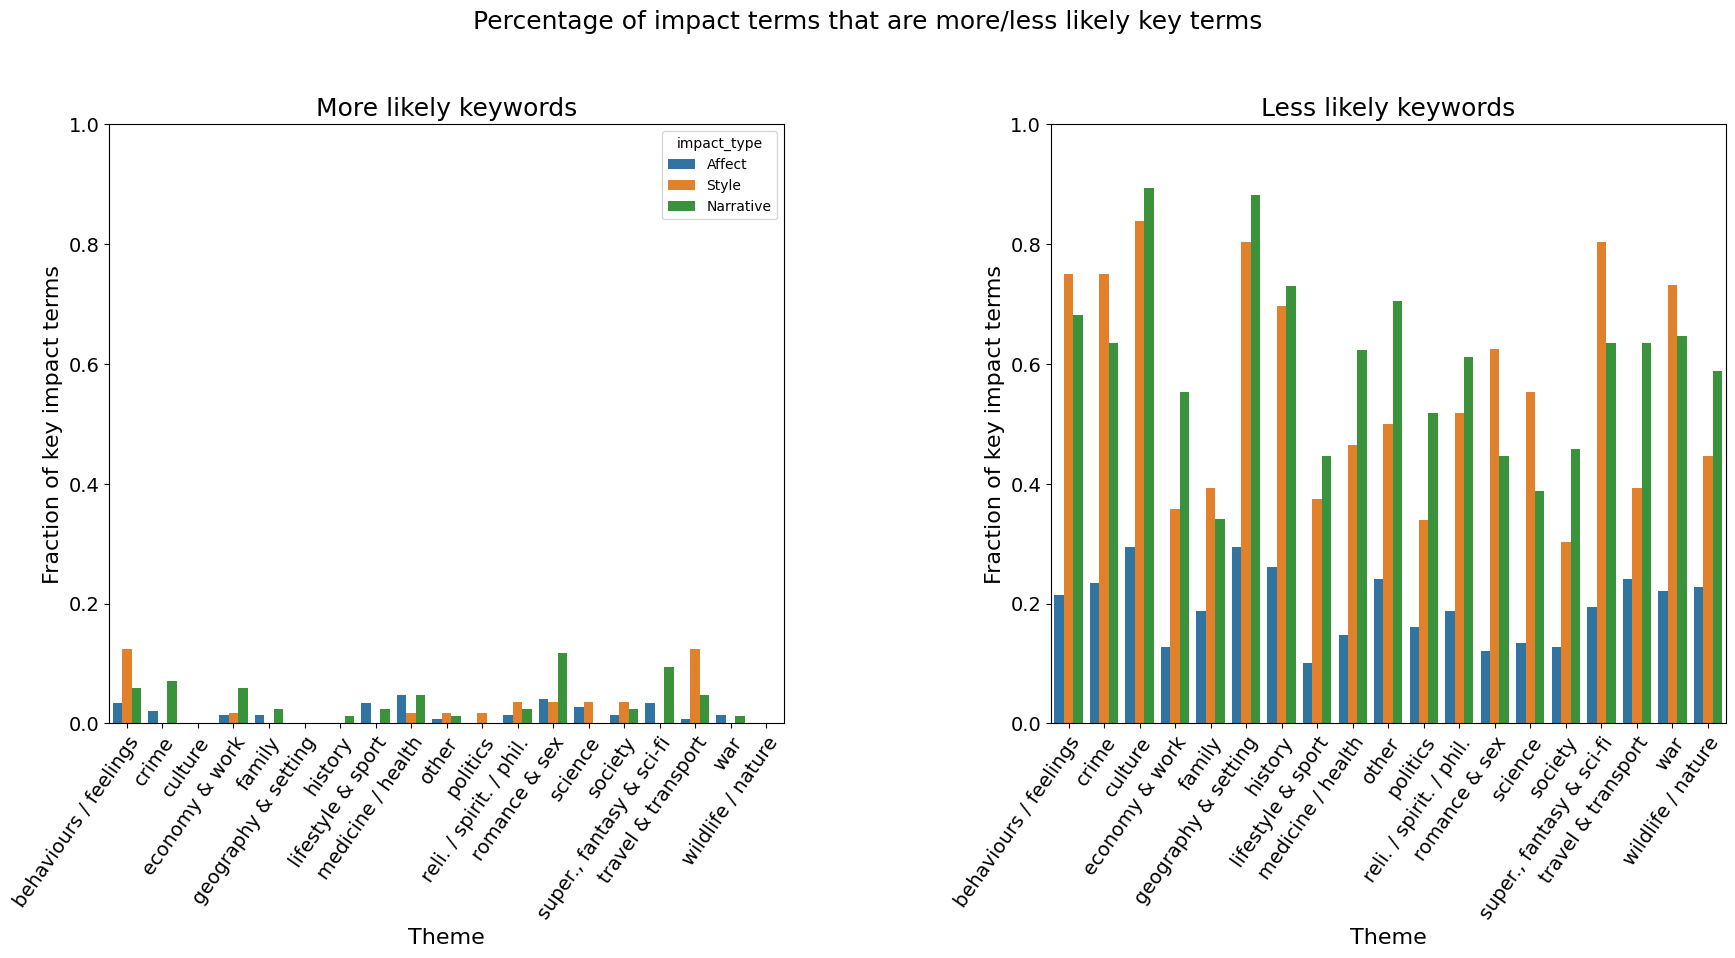

In [65]:
df_list = []
for impact_type in impact_types:
    impact_terms_frac = num_terms_theme.loc[impact_type] / num_impact_terms[impact_type]
    impact_terms_frac['impact_type'] = impact_type
    df_list.append(impact_terms_frac)

impact_terms_frac = pd.concat(df_list)


fig, ax = plt.subplots(1, 2)
sns.barplot(data=impact_terms_frac.rename(index=theme_map_short).reset_index(), x='theme', y='positive %Diff', hue='impact_type', ax=ax[0])
sns.barplot(data=impact_terms_frac.rename(index=theme_map_short).reset_index(), x='theme', y='negative %Diff', hue='impact_type', ax=ax[1])

ax[0].set_title('More likely keywords', fontsize=18)
ax[1].set_title('Less likely keywords', fontsize=18)

ax[0].set_xlabel('Theme', fontsize=16)
ax[1].set_xlabel('Theme', fontsize=16)
ax[0].set_ylabel('Fraction of key impact terms', fontsize=16)
ax[1].set_ylabel('Fraction of key impact terms', fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

# rotates labels and aligns them horizontally to left
# source: https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=55, ha="right", rotation_mode="anchor") 
plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=55, ha="right", rotation_mode="anchor") 

ax[0].set_ylim(0, 1.0)
ax[1].set_ylim(0, 1.0)

fig.suptitle('Percentage of impact terms that are more/less likely key terms', fontsize=18)

ax[1].get_legend().remove()
#ax[1].legend(bbox_to_anchor=(1, 1))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)

fig.set_size_inches(18, 10)
plt.tight_layout(w_pad=12, pad=3)

fig.savefig('../images/num_key_terms_per_theme.png', dpi=150)

### Plot correlations of %Diff scores between themes

Each impact term has a %Diff score for each theme. Some themes might have similar %Diff scores for the same impact terms. A Pearson correlation ($\rho$) score is a crude measure, but it gives an indication of the similarity or difference between two pairs of themes. 

In [66]:
# Use the dataframe_image package to save correlation tables as images
import dataframe_image as dfi

In [67]:
(percent_diff[percent_diff.impact_type == 'Style']
 #.rename(columns=theme_map_short)
 #.drop(['Non-fic', 'Oth. fic'], axis=1)
 .drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None))

,behaviours / feelings,crime,culture,economy & work,family,geography & setting,history,lifestyle & sport,medicine / health,other,politics,reli. / spirit. / phil.,romance & sex,science,society,"super., fantasy & sci-fi",travel & transport,war,wildlife / nature
behaviours / feelings,1.00,-0.28,0.03,0.03,0.48,-0.51,-0.36,0.45,0.18,-0.25,-0.08,-0.25,0.71,0.52,0.09,0.27,0.04,-0.35,0.06
crime,-0.28,1.00,0.02,0.19,-0.20,0.35,-0.34,-0.36,-0.15,-0.37,0.14,0.02,-0.05,-0.08,0.11,0.02,0.00,0.24,0.03
culture,0.03,0.02,1.00,-0.25,0.27,0.49,-0.55,-0.06,-0.14,-0.55,-0.13,-0.07,-0.10,0.03,0.34,-0.28,0.29,0.13,0.17
economy & work,0.03,0.19,-0.25,1.00,-0.16,-0.12,-0.17,0.13,0.74,-0.20,0.58,0.47,-0.02,-0.02,0.43,0.13,-0.08,-0.02,0.14
family,0.48,-0.20,0.27,-0.16,1.00,-0.15,-0.34,0.16,-0.11,-0.27,-0.06,-0.21,0.11,0.50,0.16,-0.00,0.25,0.01,0.08
geography & setting,-0.51,0.35,0.49,-0.12,-0.15,1.00,-0.39,-0.18,-0.24,-0.51,-0.11,0.42,-0.37,-0.29,0.08,-0.26,0.10,0.42,0.15
history,-0.36,-0.34,-0.55,-0.17,-0.34,-0.39,1.00,-0.22,-0.17,0.94,-0.13,-0.19,-0.30,-0.22,-0.27,-0.29,-0.42,-0.23,-0.25
lifestyle & sport,0.45,-0.36,-0.06,0.13,0.16,-0.18,-0.22,1.00,0.22,-0.21,-0.21,0.21,0.28,0.09,0.07,0.48,-0.05,0.02,0.07
medicine / health,0.18,-0.15,-0.14,0.74,-0.11,-0.24,-0.17,0.22,1.00,-0.16,0.44,0.39,0.11,0.03,0.19,0.13,0.07,-0.10,0.19
other,-0.25,-0.37,-0.55,-0.20,-0.27,-0.51,0.94,-0.21,-0.16,1.00,-0.16,-0.31,-0.23,-0.14,-0.28,-0.25,-0.31,-0.38,-0.34


In [68]:
# Correlations between genres for affective impact terms
dfi.export(percent_diff[percent_diff.impact_type == 'Affect']
 .drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-theme-affect.png', dpi=150)

In [69]:
# Correlations between genres for narrative impact terms
dfi.export(percent_diff[percent_diff.impact_type == 'Narrative']
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-theme-narrative.png', dpi=150)

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_60811/4093758398.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .corr()


In [70]:
# Correlations between genres for stylistic impact terms
dfi.export(percent_diff[percent_diff.impact_type == 'Style']
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-theme-style.png', dpi=150)

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_60811/1703506036.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .corr()
